# Analysis and insights Python script: Retail market analysis in Barcelona
## Part 3: Data preparation

### In this part we are going to create new variables or transform the current ones to carry out the actual analysis in Part 4.

## Import the libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
import folium

## Import the data

In [23]:
con = sa.create_engine('sqlite:///data/airbnb.db')

df = pd.read_sql("df", con = con)

df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2
0,0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Eixample,la Sagrada Família,41.40556,2.17262,Entire home/apt,129,...,110m2 apartment to rent in Barcelona. Located ...,f,8,3.0,6.0,33,4.31,4.69,4.81,4835
1,1,23197,"Forum CCIB DeLuxe, Spacious, Elegant ,Christmas",90417,Sant Martí,el Besòs i el Maresme,41.41243,2.21975,Entire home/apt,195,...,"Beautiful spacious apartment, large terrace, 5...",t,5,3.0,4.0,65,4.75,4.98,4.58,3544
2,2,32711,Sagrada Familia area - Còrsega 1,135703,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,73,...,A lovely two bedroom apartment only 250 m from...,f,6,2.0,3.0,83,4.40,4.84,4.86,4491
3,3,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,174,...,Spacious apartment for large families or group...,f,9,4.0,6.0,190,4.51,4.68,4.69,4165
4,4,40983,Classical loft close to pedrera!,177617,Eixample,la Dreta de l'Eixample,41.39631,2.16832,Entire home/apt,60,...,Our cool and comfortable one bedroom apartment...,f,4,1.0,1.0,254,4.37,4.77,4.88,4835


## Preparing the variables

### Create the KPIs variables

First we are going to create the analysis variables, the ones we identified as KPIs and we are going to use as levers which affect the business.

These were 3:
- **Renting price**: we already have this one under the variable "price". But we are going to check it to make sure we understand it.
- **Availability**: we have "availability_365" but we need to transform it.
- **Property price**: we will have to create this one with external variables. It's going to be the last variable to be considered.

**Let's start with the renting price**

The dataset does not say if this price is for the whole property or if it is the renting price for a bedroom in case of a bedroom.

This is very important, so we are going to analyse the average renting price by type of renting property.

Let's look at the district with more data to make that analysis.

In [24]:
df["neighbourhood_group"].value_counts().head(10)

Eixample               4340
Ciutat Vella           2031
Sants-Montjuïc         1205
Sant Martí             1021
Gràcia                  967
Sarrià-Sant Gervasi     448
Horta-Guinardó          254
Les Corts               240
Sant Andreu             115
Nou Barris              102
Name: neighbourhood_group, dtype: int64

In [25]:
df.query('neighbourhood_group == "Eixample"').groupby("room_type")["price"].agg("mean")

room_type
Entire home/apt    196.941322
Private room       167.653343
Shared room         41.933333
Name: price, dtype: float64

Conclusions:
- Renting an entire apartment in Eixample (centric district of Barcelona) average price is 198€.
- Renting a private room or a shared room has an average price of 194€ and 42€, respectively.
- It is clear that to compute the income of a property we need to take into account the number of bedrooms when the room type is Private or Shared room.

Multiplying the renting price by the number of bedrooms would not be accurate. You can have a property with more than one bedroom, but not being able to rent them all 100% of the time.

We should take into account the average number of bedrooms rented for each property. But we don't know it!

We are going to assume that we talked to the business owner and we have been told that such value is around 70%.

Let's create the variable total_price applying a custom function.

In [26]:
def create_total_price(record):
    if (record["beds"] > 1) & ((record["room_type"] == 'Private room') | (record["room_type"] == 'Shared room')):
        output = record["price"] * record["beds"] * 0.7
    else:
        output = record["price"]
    return(output)

df['total_price'] = df.apply(create_total_price, axis = 1)

Check that it worked correctly.

In [27]:
df[(df["room_type"] == "Private room") & (df["beds"] > 1)][["room_type","price","beds","total_price"]]

,room_type,price,beds,total_price
37,Private room,23,2.0,32.2
87,Private room,50,2.0,70.0
126,Private room,30,2.0,42.0
145,Private room,30,2.0,42.0
168,Private room,30,2.0,42.0
...,...,...,...,...
10662,Private room,39,2.0,54.6
10663,Private room,211,3.0,443.1
10677,Private room,24,2.0,33.6
10688,Private room,308,2.0,431.2


**Let's check the availability**

The variable we use for that is availability_365. It says how many days in a year time the property is NOT occupied.

We are going to transform it to the % of the year that it actually is occupied.

In [28]:
df["occupancy_rate"] = ((365 - df["availability_365"]) / 365 * 100).astype("int")
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2,total_price,occupancy_rate
0,0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Eixample,la Sagrada Família,41.40556,2.17262,Entire home/apt,129,...,8,3.0,6.0,33,4.31,4.69,4.81,4835,129.0,27
1,1,23197,"Forum CCIB DeLuxe, Spacious, Elegant ,Christmas",90417,Sant Martí,el Besòs i el Maresme,41.41243,2.21975,Entire home/apt,195,...,5,3.0,4.0,65,4.75,4.98,4.58,3544,195.0,30
2,2,32711,Sagrada Familia area - Còrsega 1,135703,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,73,...,6,2.0,3.0,83,4.40,4.84,4.86,4491,73.0,24
3,3,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,174,...,9,4.0,6.0,190,4.51,4.68,4.69,4165,174.0,61
4,4,40983,Classical loft close to pedrera!,177617,Eixample,la Dreta de l'Eixample,41.39631,2.16832,Entire home/apt,60,...,4,1.0,1.0,254,4.37,4.77,4.88,4835,60.0,26


### Tranformation of analysis variables

Some seed questions directly relate the renting price or the ocupancy rate with other variables such as the number of bedrooms, the average review score, etc.

It is better to carry out these analyses with discretised variables. Then, we are going to discretise:

- Accommodates
- Bedrooms
- Beds
- Number of reviews

**Discretise bedrooms**

First we evaluate the data distribution

<AxesSubplot:>

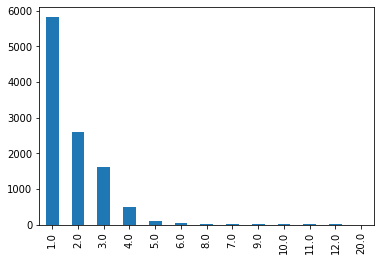

In [29]:
df["bedrooms"].value_counts().sort_values(ascending=False).plot.bar()

We are going to discretise for 1,2,3 and more than 3.

In [30]:
conditions = [df["bedrooms"] == 1,
                df["bedrooms"] == 2,
                df["bedrooms"] == 3,
                df["bedrooms"] > 3]

results = ["01_One", "02_Two", "03_Three", "04_Four or more"]

df["bedrooms_disc"] = np.select(conditions, results, default=-999)

Check it worked correctly

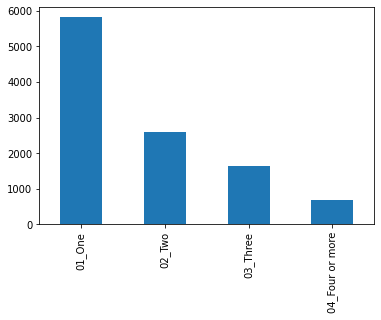

In [31]:
df["bedrooms_disc"].value_counts().plot.bar();

**Discretise accommodates, beds and number_of_reviews**

We are going to automatically discretise these variables with qcut with percentiles 0.5, 0.8 and 1.

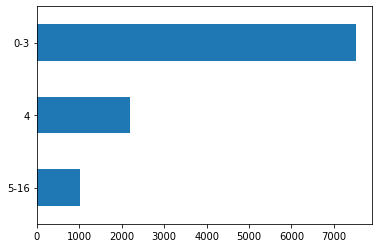

In [32]:
df["accommodates_disc"] = pd.qcut(df["accommodates"],[0, 0.5, 0.8, 1],
                                 labels = ['0-3','4','5-16'])

df["accommodates_disc"].value_counts().sort_index(ascending = False).plot.barh();

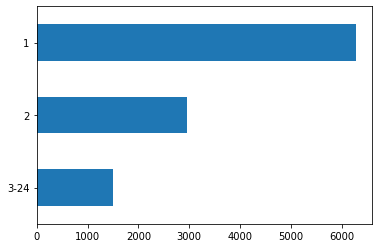

In [33]:
df["beds_disc"] = pd.qcut(df["beds"],[0, 0.5, 0.8, 1],
                         labels = ['1','2','3-24'])

df["beds_disc"].value_counts().sort_index(ascending = False).plot.barh();

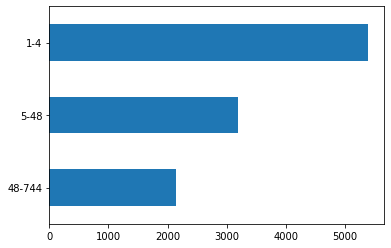

In [34]:
df["number_of_reviews_disc"] = pd.qcut(df["number_of_reviews"],[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','48-744'])

df["number_of_reviews_disc"].value_counts().sort_index(ascending = False).plot.barh();

### Create variables with external data

Here we are going to:
- Estimate the property size in m<sup>2</sup>.
- Compute the distance from each property to the city center.

**Proerty size in m<sup>2</sup>**

We already know the price per m<sup>2</sup>. Now we need to know the property size so we can compute the property price.

A good approximation will be to estimate the property size for some given number of bedrooms.

In this case:
- 1 bedroom: 50m<sup>2</sup>
- 2 bedroom: 70m<sup>2</sup>
- 3 bedroom: 90m<sup>2</sup>
- 4 bedroom: 120m<sup>2</sup>
- 5 or more bedrooms: 150m<sup>2</sup>

In [35]:
conditions = [df["bedrooms"] == 1,
                df["bedrooms"] == 2,
                df["bedrooms"] == 3,
                df["bedrooms"] == 4,
                df["bedrooms"] >= 5]

results = [50,70,90,120,150]

df["m2"] = np.select(conditions, results, default=-999)

Check it worked correctly:

In [36]:
df["m2"].value_counts().sort_index()

50     5811
70     2587
90     1626
120     500
150     199
Name: m2, dtype: int64

We can now estimate the property purchase price.

Also note that we assumed a 25% discount to the final price since the business managers can negotiate and lower that price.

In [37]:
df["purchase_price"] = df["price_m2"] * df["m2"] * 0.75

In [38]:
df[["bedrooms","m2","neighbourhood_group","price_m2","purchase_price"]].head(20)

,bedrooms,m2,neighbourhood_group,price_m2,purchase_price
0,3.0,90,Eixample,4835,326362.5
1,3.0,90,Sant Martí,3544,239220.0
2,2.0,70,Gràcia,4491,235777.5
3,4.0,120,Ciutat Vella,4165,374850.0
4,1.0,50,Eixample,4835,181312.5
5,2.0,70,Gràcia,4491,235777.5
6,2.0,70,Sant Martí,3544,186060.0
7,2.0,70,Gràcia,4491,235777.5
8,2.0,70,Eixample,4835,253837.5
9,1.0,50,Ciutat Vella,4165,156187.5


**Distance from each town to the city center**



We are going to measure the distance of each property to the city center. The city center is going to be Plaça Catalunya.

It latitude and longitude are:

- Latitude: 41.3869833 
- Longitude: 2.1713775

To compute the distance we are going to use the Haversine formula, which takes into account the spherical shape of Earth to measure distances.

The formula is based on the one from [this](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points) link.

In [39]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 # Earth radius in km. If we wanted to compute the distance in miles we should use 3959.87433.

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

We can now create the new variable.

In [40]:
# Coordinates from Plaza de España will be lat1 and lon1
lat1 = 41.3869833
lon1 = 2.1713775

df["distance_center"] = df.apply(lambda record: haversine(lat1,lon1,record["latitude"],record["longitude"]),axis = 1)

Check it works.

In [41]:
df.groupby("neighbourhood_group")["distance_center"].agg("mean").sort_values()

neighbourhood_group
Ciutat Vella           0.842412
Eixample               1.338215
Gràcia                 2.212503
Sants-Montjuïc         2.438574
Sarrià-Sant Gervasi    2.979049
Sant Martí             3.038146
Les Corts              3.500973
Horta-Guinardó         3.566981
Sant Andreu            4.545179
Nou Barris             5.454331
Name: distance_center, dtype: float64

## Save the data mart

We can now save the whole data set as df_final

In [42]:
df.to_sql("df_final", con = con, if_exists="replace")